In [1]:
!unzip dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
 extracting: dataset/content/dataset/imageb_2232.png  
  inflating: dataset/content/dataset/imagea_1881.png  
  inflating: dataset/content/dataset/out_1587.png  
 extracting: dataset/content/dataset/imageb_1816.png  
  inflating: dataset/content/dataset/imagea_1790.png  
 extracting: dataset/content/dataset/imageb_1656.png  
  inflating: dataset/content/dataset/imagea_658.png  
  inflating: dataset/content/dataset/imagea_273.png  
  inflating: dataset/content/dataset/imagea_457.png  
  inflating: dataset/content/dataset/imagea_1642.png  
 extracting: dataset/content/dataset/imageb_94.png  
 extracting: dataset/content/dataset/imageb_2004.png  
  inflating: dataset/content/dataset/out_637.png  
  inflating: dataset/content/dataset/imagea_719.png  
  inflating: dataset/content/dataset/imagea_1844.png  
 extracting: dataset/content/dataset/imageb_2213.png  
  inflating: dataset/content/dataset/out_1478.png  
 extracting: dataset/content/d

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imagea_files = [f for f in os.listdir(img_dir) if f.startswith("imagea_")]
        self.imagea_files.sort()

    def __len__(self):
        return len(self.imagea_files)

    def __getitem__(self, idx):
        img_a_path = os.path.join(self.img_dir, self.imagea_files[idx])
        img_out_path = os.path.join(self.img_dir, self.imagea_files[idx].replace("imagea", "out"))

        img_a = Image.open(img_a_path).convert("RGB")
        img_out = Image.open(img_out_path).convert("RGB")

        if self.transform:
            img_a = self.transform(img_a)
            img_out = self.transform(img_out)

        return img_a, img_out

img_dir = "dataset/content/dataset/"  # Replace with the path to your images
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = MyDataset(img_dir, transform)

train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_data, test_data, val_data = random_split(dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=True)

# Autoencoder 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for img_a, img_out in train_loader:
        img_a = img_a.cuda()
        img_out = img_out.cuda()

        optimizer.zero_grad()

        outputs = model(img_a)

        loss = criterion(outputs, img_out)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for img_a, img_out in val_loader:
            img_a = img_a.cuda()
            img_out = img_out.cuda()

            outputs = model(img_a)

            val_loss = criterion(outputs, img_out)
            running_val_loss += val_loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {running_val_loss / len(val_loader)}")


Input Image:


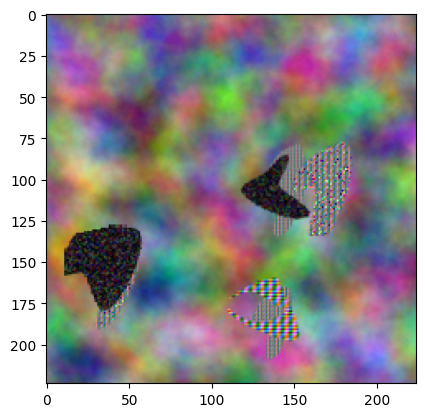

Model Output Image:


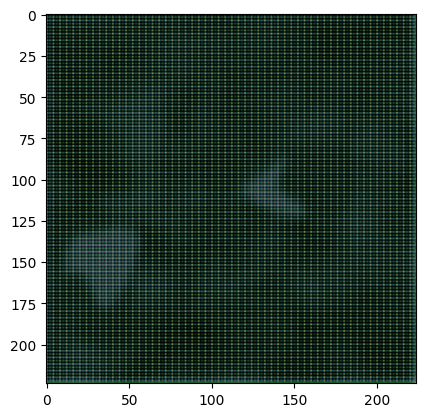

Target Output Image:


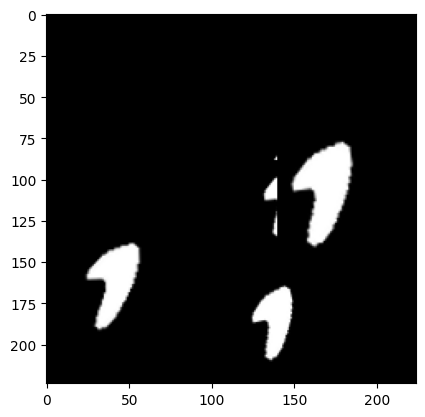

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

# Pick a random sample from the test dataset
index = np.random.randint(0, len(test_data))
img_a, img_out = test_data[index]

# Pass the sample through the model
model.eval()
with torch.no_grad():
    img_a_cuda = img_a.unsqueeze(0).cuda()
    output = model(img_a_cuda).squeeze(0)

# Display the input image, output image, and target output image
print("Input Image:")
imshow(img_a)

print("Model Output Image:")
imshow(output)

print("Target Output Image:")
imshow(img_out)


In [ ]:
from google.colab import files

torch.save(model, 'mymodel_new.pt')

files.download('mymodel_new.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>